In [1]:
# import the necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import cv2
import os
import csv

## Modules to check the performance of the code
from time import process_time 


## Importing the necessary TesnorFLow modules modules
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score ## form calcualting the r2 score
from sklearn.utils import shuffle
from tensorflow import keras as k
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras_tuner as kt

## Trasfer Learning Models

from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1 
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5 
from tensorflow.keras.applications import EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import ResNet50,ResNet50V2
import re

## Modules for hyperparameter tuning keras-tuner
# import keras_tuner as kt

## Checking the availbale number of GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:",gpu.name,"Type:",gpu.device_type)
print("TensorFlow version used ",tf.__version__)

Num GPUs Available:  1
Name: /physical_device:GPU:0 Type: GPU
TensorFlow version used  2.10.0


In [2]:
#### Folder management
############ Please provide the path to the code directory if using Colab ################

# Path_gdrive= '/content/drive/MyDrive/ISU_Regresion/DPNNet-RT/' ## Comment out this line if using local computer

## Importing the Modules from Modules_DPNNet
import sys
try: ## tries to find the modules in the local directory first
  current_directory = os.getcwd()
  path = current_directory + '/' # For local computer 
#   path = '' # For local computer  
  sys.path.append(path+'MODULES_DPNNeT')
  import data_processing_RT as dp
  import deep_models as dm
  import other_cnns as ocn

########### Folders to save the processed data, files and figures when using Local computer ##############
  output_folder_list = ['data_folder','figures','saved_model']
  for file in output_folder_list:
    try:
        os.makedirs(file)
    except OSError:
        print ("Creation of the directory %s failed/ not needed as it already exit" % file)
    else:
        print ("Successfully created the directory %s" % file)
  
except ModuleNotFoundError:
  
  # #For Colab use:
  # #Point to the path containing the modules in the above section
  #(data folder are a directory above the directory containing the notebook)
  try:
    path = Path_gdrive
    print(path)
    sys.path.append(path+'MODULES_DPNNeT')
    import data_processing_RT as dp
    import deep_models as dm
    import other_cnns as ocn

    ########### Folders to save the processed data, files and figures when using GDRIVE ##############
    import os
    os.chdir(path)
    print("Creating the folders")
    !mkdir -p data_folder
    !mkdir -p figures ## to save the figures
    !mkdir -p figures_paper
    !mkdir -p saved_model
  except ModuleNotFoundError:
    print("The path to the modules is incorrect-- Provide current path")

print("[INFO] Modules imported")

We are currently using the Modules_DPCNet-RT
Creation of the directory data_folder failed/ not needed as it already exit
Creation of the directory figures failed/ not needed as it already exit
Creation of the directory saved_model failed/ not needed as it already exit
[INFO] Modules imported


In [3]:
parameter_df = dp.load_parameter_csv(path)

In [4]:
#### Desired Image resoltuion  and Batch Size #####
X_res = Y_res = 256

## For random sampling from the images
num_sims = 700 
axisymmetric = True
num_ims_per_sim = 30  ## Choose the number of images from each FARGO3D sims

## Select the kind of Traning ## Both can be selected as well
REG =False#True  ## When choosing regression
CLA =True #False #False #True  ## When Choosing Clasiffication

hyperparam_tune = False ## Only used when classification is true 

Cutoff_resolution = 600

## Select the Network type

# NETWORK = "Vanilla" ## Cannot be uses at the moment
# NETWORK = "ALEXNET"
# NETWORK = "VGG"
# NETWORK = "RESNET50"

                                ########## When using Trasnfer Learning ######################
NETWORK = "TL"
#transfer_model= ResNet50
transfer_model=EfficientNetB3

## Hyper-Parameter to define
batch_size = 50 ## 20 was for regression ## the best was for 200 last run
valid_batch_size = 100
epochs=100 ## best was 100
init_lr = 1e-5 # 1e-5 (works for regression)

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
early_stop = keras.callbacks.EarlyStopping(monitor='mean_absolute_error', min_delta=1e-5,
                                           patience=20, verbose=1, mode='min',restore_best_weights=True)

In [5]:
############# Address to the data folder ###################

# ## updating the image paths once the transfer is done
try:     
    list_RT_path = glob.glob(path+ 'image_directory_complete/'+ 'RT_A*') ## make a list of all the RT folder where each folder is for each sim
    # ## For google colab this needs to be updated
    list_sorted_RT_path  = sorted(list_RT_path, key=lambda f: [int(n) for n in re.findall(r"\d+", f)][-1]) ## sorting the images
    data_complete = dp.create_complete_data_csv(list_sorted_RT_path,path)
except ValueError:
    print("Looking for images in the folder above-- Please give the correct path to the images if images are not loaded")
    list_RT_path = glob.glob(path+ '../image_directory_complete/'+ 'RT_A*') ## make a list of all the RT folder where each folder is for each sim
    # ## For google colab this needs to be updated
    list_sorted_RT_path  = sorted(list_RT_path, key=lambda f: [int(n) for n in re.findall(r"\d+", f)][-1]) ## sorting the images
    data_complete = dp.create_complete_data_csv(list_sorted_RT_path,path)

## Removing the nan if any
data_complete.isna().sum()  # summing the number of na
data_complete= data_complete.dropna()
data_complete = shuffle(data_complete,random_state=42)
dc_list = []

for  i in range(1, num_sims+1):
  if axisymmetric == True:
    dc_list.append(data_complete.loc[data_complete['image_path'].str.contains('RT_A_' + str(i))][:num_ims_per_sim])
  else:
    dc_list.append(data_complete.loc[data_complete['image_path'].str.contains('RT_NA_' + str(i))][:num_ims_per_sim])

data_complete = pd.concat(dc_list)
data_complete = shuffle(data_complete,random_state=49)

def f(row):
    if (row['Planet_Mass1'] != 0) and (row['Planet_Mass2'] == 0) and (row['Planet_Mass3'] == 0):
        val = 1
    elif (row['Planet_Mass1'] != 0) and (row['Planet_Mass2'] == 0) and (row['Planet_Mass3'] != 0):
        val = 2
    elif (row['Planet_Mass1'] != 0) and (row['Planet_Mass2'] != 0) and (row['Planet_Mass3'] == 0):
        val = 3
    elif (row['Planet_Mass1'] != 0) and (row['Planet_Mass2'] != 0) and (row['Planet_Mass3'] != 0):
        val = 4
    return val

data_complete['Planet_Count'] = data_complete.apply(f, axis=1)
data_complete

[INFO]: Importing path for all the RT images
[INFO]: Contatination of the paths of all the RT images are now complete


,Planet_Mass1,Planet_Mass2,Planet_Mass3,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Flaring_Index,Rp1,Rp2,Rp3,a_grain_mic,image_path,Planet_Count
70957,164.000000,0.000000,182.333333,0.050,0.0500,0.001570,0.0346,1.0,0.010,1.080,1.92,3.25,300.0,/Users/subhrat/DPNNet-RT/image_directory_compl...,2
74841,107.333333,60.000000,240.000000,0.025,0.0100,0.001570,0.0646,1.0,0.075,0.954,2.02,3.49,300.0,/Users/subhrat/DPNNet-RT/image_directory_compl...,4
66658,390.000000,261.000000,793.333333,0.050,0.0100,0.001570,0.0604,1.0,0.250,0.863,2.02,3.49,300.0,/Users/subhrat/DPNNet-RT/image_directory_compl...,4
63900,305.666667,483.333333,930.000000,0.010,0.0010,0.001570,0.0625,1.0,0.010,1.060,2.01,3.23,300.0,/Users/subhrat/DPNNet-RT/image_directory_compl...,4
76580,503.333333,0.000000,0.000000,0.010,0.0001,0.001570,0.0475,1.0,0.075,1.150,2.01,3.47,300.0,/Users/subhrat/DPNNet-RT/image_directory_compl...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40212,420.000000,0.000000,0.000000,0.025,0.0010,0.015700,0.0968,1.0,0.075,1.190,2.02,3.32,3000.0,/Users/subhrat/DPNNet-RT/image_directory_compl...,1
39626,900.000000,0.000000,0.000000,0.025,0.0050,0.015700,0.0496,1.0,0.250,1.150,2.08,3.37,1000.0,/Users/subhrat/DPNNet-RT/image_directory_compl...,1
98225,446.666667,333.333333,240.000000,0.025,0.0050,0.000157,0.0411,1.0,0.010,0.851,1.89,3.27,100.0,/Users/subhrat/DPNNet-RT/image_directory_compl...,4
79263,50.666667,0.000000,0.000000,0.010,0.0050,0.001570,0.0411,1.0,0.010,1.190,1.97,3.22,100.0,/Users/subhrat/DPNNet-RT/image_directory_compl...,1


In [6]:
split_1 = train_test_split(data_complete, test_size=0.15, random_state=42)
(train, test) = split_1
split_2 = train_test_split(train, test_size=0.15, random_state=42)
(train, val) = split_2

## Save the train and the test data for future use as well.
test.to_csv(path+'data_folder/test_dataset.csv')
val.to_csv(path+'data_folder/val_dataset.csv')
train.to_csv(path+'data_folder/train_dataset.csv')

## Generate the Normalized data
normed_train_data, normed_test_data, normed_val_data, train_labels, test_labels, val_labels, Y_train, Y_val, Y_test = dp.process_the_disk_attributes(train, test, val, path, multi_label=True)

[INFO] preparing the normalized data training/testing split...
Droping the irrelevant columns 
INFO: considering multiple planets as output
[INFO] Done...


In [7]:
import time
start = time.time()

if CLA == True:

        y_col = ['Planet_Count']

elif REG == True:
        y_col=["Planet_Mass1",'Planet_Mass2','Planet_Mass3']

        
        ###### Generate the training and the test images######
if X_res >= Cutoff_resolution:
    
    def custom_augmentation(np_tensor):

        '''
        This function is used to crop the images when those are loaded using the 
        ImageDataGenerator Keras function. This custom augmentation function only
        works for three different res as given below. For other resolutions the 
        image needs to the cropped appropiately.

        '''

        # # # dimensions for cropping the image
        if X_res == 64:
          top,left,bottom,right = 10,12,55,45
        if X_res == 128:
          top,left,bottom,right = 20,25,110,90 
        if X_res == 256:          
          top,left,bottom,right = 40,50,220,180          
        if X_res == 512:
          top,left,bottom,right = 80,100,440,360      
                
        image = np.squeeze(np_tensor) 
        crop_image = image[top:bottom, left:right]
        crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
        crop_image = k.preprocessing.image.img_to_array(crop_image)
        return crop_image

#     datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,samplewise_center=True, samplewise_std_normalization=True,rescale=1./255.,validation_split=0.15)
#     datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,featurewise_center=True,featurewise_std_normalization=True,rescale=1./255.,validation_split=0.15)
    if transfer_model == ResNet50:
        datagen= k.preprocessing.image.ImageDataGenerator(preprocessing_function=custom_augmentation,featurewise_center=True, zca_whitening=True,rescale=1./255.,validation_split=0.15)
    else:
        datagen= k.preprocessing.image.ImageDataGenerator(preprocessing_function=custom_augmentation,featurewise_center=True, zca_whitening=True,rescale=1./255.,validation_split=0.15)

    #### TRAINING GENERATOR #####
    train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="image_path",
    y_col=y_col,
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(X_res,Y_res))

    #### VALIDATION GENERATOR #####
    validation_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="image_path",
    y_col=y_col,
    subset="validation",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(X_res,Y_res))

    #### TESTING GENERATOR #####
    test_datagen= k.preprocessing.image.ImageDataGenerator(preprocessing_function=custom_augmentation,featurewise_center=True, zca_whitening=True,rescale=1./255.)
    test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="image_path",
    y_col=y_col,
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(X_res,Y_res))
    
    
    ## STEP SIZES later used for training using generators
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

 

else:
    print("Uploading directly to RAM as the image resoltuion is manageable")
    trainImagesX = dp.load_disk_images(train, X_res, Y_res, Type = "Train")
    valImagesX = dp.load_disk_images(val, X_res, Y_res, Type = "Val")
    testImagesX = dp.load_disk_images(test, X_res, Y_res, Type = "Test")

Validation_split = 0.15 # 15 percent of the training data is used for validation
print('There are {} Train, {} Validation and {} Test images'.format(len(normed_train_data),len(normed_val_data),len(normed_test_data)))## check the numbers in each category
end = time.time()
print("Total time elapsed =", end - start)

Uploading directly to RAM as the image resoltuion is manageable
[INFO] Loading images from Train data..


/opt/miniconda3/envs/proj/lib/python3.9/site-packages/keras/preprocessing/image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/miniconda3/envs/proj/lib/python3.9/site-packages/keras/preprocessing/image.py:1886: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Train Images are loaded
[INFO] Loading images from Val data..
Val Images are loaded
[INFO] Loading images from Test data..
Test Images are loaded
There are 15172 Train, 2678 Validation and 3150 Test images
Total time elapsed = 185.96451711654663


(256, 256, 3)


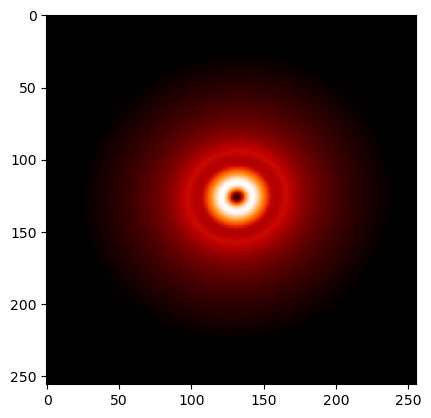

(256, 256, 3)


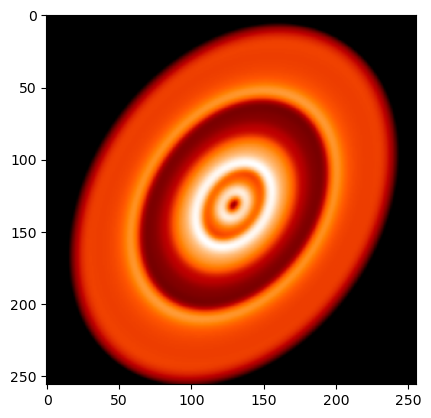

(256, 256, 3)


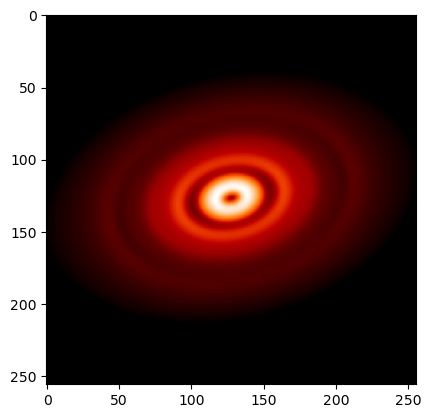

(256, 256, 3)


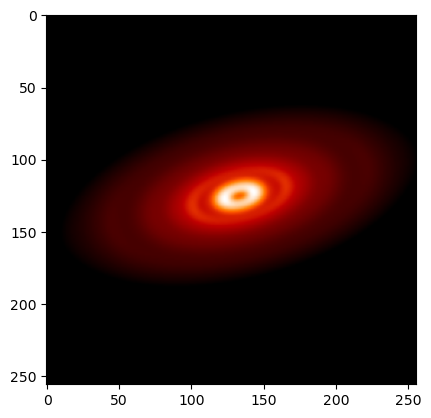

(256, 256, 3)


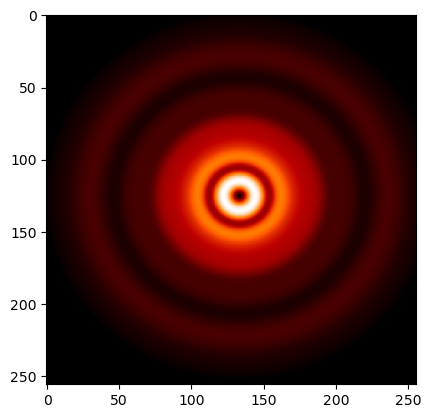

In [8]:
if X_res>= Cutoff_resolution:
    for _ in range(5):
        img, label = train_generator.next()
        print(img.shape)   #  (1,256,256,3)
        plt.imshow(img[0])
        plt.show()
else:
    for i in range(5):
        print(valImagesX[i].shape)   #  (1,256,256,3)
        plt.imshow(valImagesX[i])
        plt.grid(False)
        plt.show()

In [9]:
CNN = tf.keras.models.load_model(path+'data_for_subhrat_20M23/'+'TL_ResNet50_256_modelR')
actual = test_labels # Y_test
predicted = CNN.predict(testImagesX) # np.concatenate(CNN.predict(testImagesX))

CNN_C = tf.keras.models.load_model(path+'data_for_subhrat_20M23/'+'TL_ResNet50_256_modelC')
actual_planet_mass = test_labels.to_numpy().flatten()
pred_planet_mass = predicted.flatten()
actual_cp_label = np.repeat(Y_test.to_numpy(),3)
predicted_cp_label = np.repeat(np.concatenate(CNN_C.predict(testImagesX)),3)

R2_FP_dataset_og = pd.DataFrame(list(zip(actual_planet_mass, pred_planet_mass, actual_cp_label, predicted_cp_label, np.log10(np.abs(pred_planet_mass/(actual_planet_mass))), np.log10(predicted_cp_label/actual_cp_label))),
columns =['actual_planet_mass', 'pred_planet_mass', 'actual_cp_label', 'predicted_cp_label', r'$log_{10}(M_{P_{Predicted}}/M_{P_{Actual}})$', r'$log_{10}(CP_{Predicted}/CP_{Actual})$'])
R2_FP_dataset = R2_FP_dataset_og.drop(R2_FP_dataset_og[R2_FP_dataset_og.actual_planet_mass <= 0].index)
grouped = R2_FP_dataset.groupby(R2_FP_dataset['actual_cp_label'])
R2_FP_dataset_1 = grouped.get_group(1)
R2_FP_dataset_2 = grouped.get_group(2)
R2_FP_dataset_3 = grouped.get_group(3)
R2_FP_dataset_4 = grouped.get_group(4)

grouped_og = R2_FP_dataset_og.groupby(R2_FP_dataset_og['actual_cp_label'])
R2_FP_dataset_1_og = grouped_og.get_group(1)
R2_FP_dataset_2_og = grouped_og.get_group(2)
R2_FP_dataset_3_og = grouped_og.get_group(3)
R2_FP_dataset_4_og = grouped_og.get_group(4)

df_64 = pd.read_csv(path+'data_for_subhrat_20M23/'+'TL_ResNet50_64_modelC_history.csv')
df_128 = pd.read_csv(path+'data_for_subhrat_20M23/'+'TL_ResNet50_128_modelC_history.csv')
df_256 = pd.read_csv(path+'data_for_subhrat_20M23/'+'TL_ResNet50_256_modelC_history.csv')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-10-23 17:45:52.411382: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-23 17:45:52.411590: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-10-23 17:46:00.854751: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-23 17:46:01.289574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 63s 620ms/step


2024-10-23 17:47:13.220827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 67s 659ms/step


/var/folders/hc/r7dfp_9n1kz9cl4mvp0p617r0000gn/T/ipykernel_67655/2390447963.py:11: RuntimeWarning: divide by zero encountered in divide
  R2_FP_dataset_og = pd.DataFrame(list(zip(actual_planet_mass, pred_planet_mass, actual_cp_label, predicted_cp_label, np.log10(np.abs(pred_planet_mass/(actual_planet_mass))), np.log10(predicted_cp_label/actual_cp_label))),


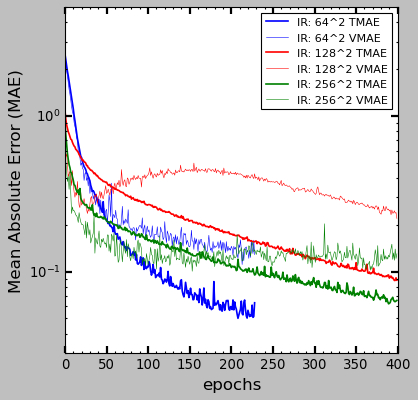

In [10]:
plt.style.use('classic')


plt.figure(figsize=(5, 5))
# plt.subplot(2, 2, 1)
plt.plot(df_64['Unnamed: 0'], df_64['mean_absolute_error'], label='IR: 64^2 TMAE', linewidth = 1.5, color = 'blue')
plt.plot(df_64['Unnamed: 0'], df_64['val_mean_absolute_error'], label='IR: 64^2 VMAE', linewidth = 0.5, color = 'blue')

plt.plot(df_128['Unnamed: 0'], df_128['mean_absolute_error'], label='IR: 128^2 TMAE', linewidth = 1.5, color = 'red')
plt.plot(df_128['Unnamed: 0'], df_128['val_mean_absolute_error'], label='IR: 128^2 VMAE', linewidth = 0.5, color = 'red')

plt.plot(df_256['Unnamed: 0'], df_256['mean_absolute_error'], label='IR: 256^2 TMAE', linewidth = 1.5, color = 'green')
plt.plot(df_256['Unnamed: 0'], df_256['val_mean_absolute_error'], label='IR: 256^2 VMAE', linewidth = 0.5, color = 'green')

plt.minorticks_on() 
plt.tick_params(labelsize=12)
plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=2, width=1)

plt.tight_layout()
plt.legend(numpoints=1,loc='upper right',fancybox=False,shadow=False, fontsize = 10)

plt.ylim(3e-2,5)

plt.xlabel("epochs", fontsize=15)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=15)
plt.yscale('log')
plt.savefig('figures/'+'TC_MAE'+'_C.png',format='png',dpi=500,bbox_inches = 'tight')
plt.show()

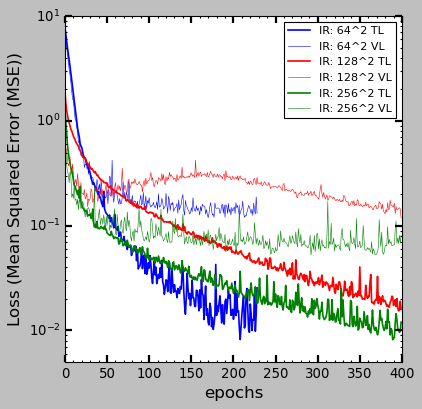

In [11]:
plt.style.use('classic')


plt.figure(figsize=(5, 5))
# plt.subplot(2, 2, 1)
plt.plot(df_64['Unnamed: 0'], df_64['loss'], label='IR: 64^2 TL', linewidth = 1.5, color = 'blue')
plt.plot(df_64['Unnamed: 0'], df_64['val_loss'], label='IR: 64^2 VL', linewidth = 0.5, color = 'blue')

plt.plot(df_128['Unnamed: 0'], df_128['loss'], label='IR: 128^2 TL', linewidth = 1.5, color = 'red')
plt.plot(df_128['Unnamed: 0'], df_128['val_loss'], label='IR: 128^2 VL', linewidth = 0.5, color = 'red')

plt.plot(df_256['Unnamed: 0'], df_256['loss'], label='IR: 256^2 TL', linewidth = 1.5, color = 'green')
plt.plot(df_256['Unnamed: 0'], df_256['val_loss'], label='IR: 256^2 VL', linewidth = 0.5, color = 'green')

plt.minorticks_on() 
plt.tick_params(labelsize=12)
plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=2, width=1)

plt.tight_layout()
plt.legend(numpoints=1,loc='upper right',fancybox=False,shadow=False, fontsize = 10)

plt.ylim(5e-3,10)

plt.xlabel("epochs", fontsize=15)
plt.ylabel("Loss (Mean Squared Error (MSE))", fontsize=15)
plt.yscale('log')
plt.savefig('figures/'+'TC_loss'+'_C.png',format='png',dpi=500,bbox_inches = 'tight')
plt.show()

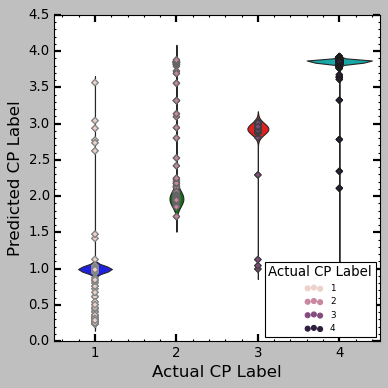

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('classic')

plt.figure(figsize=(5, 5))

sns.violinplot (x = 'actual_cp_label', y = 'predicted_cp_label', data = R2_FP_dataset_og)
sns.stripplot(x = 'actual_cp_label', y = 'predicted_cp_label', data = R2_FP_dataset_og, hue="actual_cp_label", jitter=False, s=4, marker="D", linewidth=1, alpha=1)

plt.minorticks_on() 
plt.tick_params(labelsize=12)
plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=2, width=1)

plt.tight_layout()
plt.legend(numpoints=1,loc='lower right',fancybox=False,shadow=False, fontsize = 8, title = "Actual CP Label")


plt.xlabel("Actual CP Label", fontsize=15)
plt.ylabel("Predicted CP Label", fontsize=15)
plt.savefig('figures/'+'violin'+'_C.png',format='png',dpi=500,bbox_inches = 'tight')
plt.show()

<Figure size 400x400 with 0 Axes>

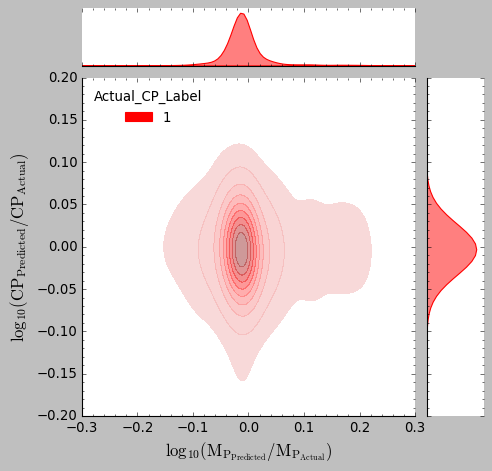

In [22]:
plt.style.use('classic')
plt.figure(figsize=(5, 5))
unique = R2_FP_dataset['actual_cp_label'].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
joint_kws=dict(gridsize=800)
graph=sns.jointplot(data=R2_FP_dataset_1, x='$log_{10}(M_{P_{Predicted}}/M_{P_{Actual}})$', y='$log_{10}(CP_{Predicted}/CP_{Actual})$', 
              hue="actual_cp_label", kind="kde", legend = "lower right", fill=True, thresh = 0.05, alpha=0.5, palette = palette, 
                    marginal_kws=dict(palette = palette, fill=True, hue="actual_cp_label", alpha=0.5), joint_kws = joint_kws)
# graph.plot_marginals(sns.kdeplot, hue="actual_cp_label", fill=True, alpha=.2, legend = True)

plt.xlim(-0.3,0.3)
plt.ylim(-0.2,0.2)
plt.xlabel(r'$\mathrm{log_{10}(M_{P_{Predicted}}/M_{P_{Actual}})}$', fontsize = 15)
plt.ylabel(r'$\mathrm{log_{10}(CP_{Predicted}/CP_{Actual})}$', fontsize = 15)
sns.move_legend(graph.ax_joint, "upper left", title='Actual_CP_Label', frameon=False, fontsize = 12)
plt.minorticks_on()
plt.savefig('figures/'+'JP_1'+'.png',format='png',dpi=1024,bbox_inches = 'tight')
plt.show()

<Figure size 400x400 with 0 Axes>

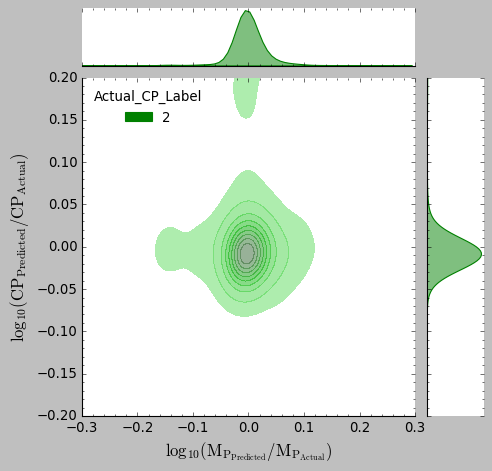

In [23]:
plt.style.use('classic')
plt.figure(figsize=(5, 5))
unique = R2_FP_dataset['actual_cp_label'].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
joint_kws=dict(gridsize=800)
graph=sns.jointplot(data=R2_FP_dataset_2, x='$log_{10}(M_{P_{Predicted}}/M_{P_{Actual}})$', y='$log_{10}(CP_{Predicted}/CP_{Actual})$', 
              hue="actual_cp_label", kind="kde", legend = "lower right", fill=True, thresh = 0.05, alpha=0.5, palette = palette, 
                    marginal_kws=dict(palette = palette, fill=True, hue="actual_cp_label", alpha=0.5), joint_kws = joint_kws)
# graph.plot_marginals(sns.kdeplot, hue="actual_cp_label", fill=True, alpha=.2, legend = True)

plt.xlim(-0.3,0.3)
plt.ylim(-0.2,0.2)
plt.xlabel(r'$\mathrm{log_{10}(M_{P_{Predicted}}/M_{P_{Actual}})}$', fontsize = 15)
plt.ylabel(r'$\mathrm{log_{10}(CP_{Predicted}/CP_{Actual})}$', fontsize = 15)
sns.move_legend(graph.ax_joint, "upper left", title='Actual_CP_Label', frameon=False, fontsize = 12)
plt.minorticks_on()
plt.savefig('figures/'+'JP_2'+'.png',format='png',dpi=1024,bbox_inches = 'tight')
plt.show()

<Figure size 400x400 with 0 Axes>

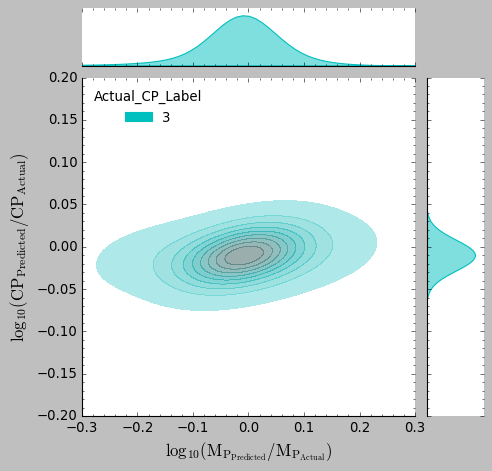

In [24]:
plt.style.use('classic')
plt.figure(figsize=(5, 5))
unique = R2_FP_dataset['actual_cp_label'].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
joint_kws=dict(gridsize=800)
graph=sns.jointplot(data=R2_FP_dataset_3, x='$log_{10}(M_{P_{Predicted}}/M_{P_{Actual}})$', y='$log_{10}(CP_{Predicted}/CP_{Actual})$', 
              hue="actual_cp_label", kind="kde", legend = "lower right", fill=True, thresh = 0.05, alpha=0.5, palette = palette, 
                    marginal_kws=dict(palette = palette, fill=True, hue="actual_cp_label", alpha=0.5), joint_kws = joint_kws)
# graph.plot_marginals(sns.kdeplot, hue="actual_cp_label", fill=True, alpha=.2, legend = True)

plt.xlim(-0.3,0.3)
plt.ylim(-0.2,0.2)
plt.xlabel(r'$\mathrm{log_{10}(M_{P_{Predicted}}/M_{P_{Actual}})}$', fontsize = 15)
plt.ylabel(r'$\mathrm{log_{10}(CP_{Predicted}/CP_{Actual})}$', fontsize = 15)
sns.move_legend(graph.ax_joint, "upper left", title='Actual_CP_Label', frameon=False, fontsize = 12)
plt.minorticks_on()
plt.savefig('figures/'+'JP_3'+'.png',format='png',dpi=1024,bbox_inches = 'tight')
plt.show()

<Figure size 400x400 with 0 Axes>

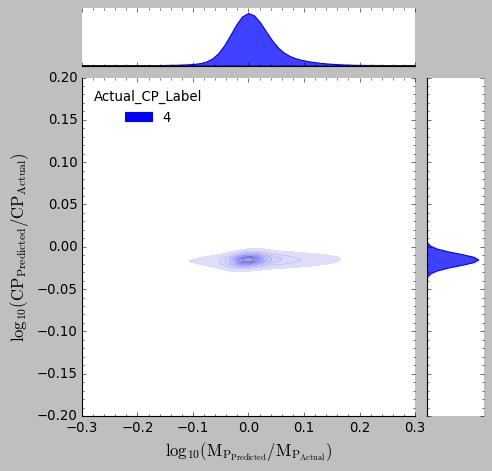

In [25]:
import seaborn as sns

plt.style.use('classic')
plt.figure(figsize=(5, 5))
unique = R2_FP_dataset['actual_cp_label'].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
joint_kws=dict(gridsize=800)
graph=sns.jointplot(data=R2_FP_dataset_4, x='$log_{10}(M_{P_{Predicted}}/M_{P_{Actual}})$', y='$log_{10}(CP_{Predicted}/CP_{Actual})$', 
              hue="actual_cp_label", kind="kde", legend = "lower right", fill=True, thresh = 0.05, alpha=0.5, palette = palette, 
                    marginal_kws=dict(palette = palette, fill=True, hue="actual_cp_label", alpha=0.75, bw_adjust = 2.3), joint_kws = joint_kws)

plt.xlim(-0.3,0.3)
plt.ylim(-0.2,0.2)
plt.xlabel(r'$\mathrm{log_{10}(M_{P_{Predicted}}/M_{P_{Actual}})}$', fontsize = 15)
plt.ylabel(r'$\mathrm{log_{10}(CP_{Predicted}/CP_{Actual})}$', fontsize = 15)
sns.move_legend(graph.ax_joint, "upper left", title='Actual_CP_Label', frameon=False, fontsize = 12)
plt.minorticks_on()
plt.savefig('figures/'+'JP_4'+'.png',format='png',dpi=1024,bbox_inches = 'tight')
plt.show()

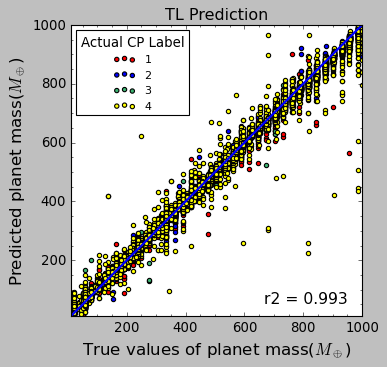

In [17]:
import cfpack as mt

plt.style.use('classic')
plt.figure(figsize = (5,5))
# test_predictions = model.predict(normed_test_data).flatten()
cdict = {1: 'red', 2: 'blue', 3: 'mediumseagreen', 4: 'yellow'}
# for g in np.unique(R2_FP_dataset['actual_cp_label']):
#     ix = np.where(R2_FP_dataset['actual_cp_label'] == g)
#     plt.scatter([R2_FP_dataset['actual_planet_mass'][i] for i in ix[0]],[R2_FP_dataset['pred_planet_mass'][i] for i in ix[0]],s=15,marker='o',c=cdict[g], label = g)

plt.scatter(R2_FP_dataset_1_og['actual_planet_mass'],R2_FP_dataset_1_og['pred_planet_mass'],s=15,marker='o',c=cdict[1], label = '1')
plt.scatter(R2_FP_dataset_2_og['actual_planet_mass'],R2_FP_dataset_2_og['pred_planet_mass'],s=15,marker='o',c=cdict[2], label = '2')
plt.scatter(R2_FP_dataset_3_og['actual_planet_mass'],R2_FP_dataset_3_og['pred_planet_mass'],s=15,marker='o',c=cdict[3], label = '3')
plt.scatter(R2_FP_dataset_4_og['actual_planet_mass'],R2_FP_dataset_4_og['pred_planet_mass'],s=15,marker='o',c=cdict[4], label = '4')

score_CNN = r2_score(R2_FP_dataset_og['actual_planet_mass'],R2_FP_dataset_og['pred_planet_mass'])
plt.text(650,55,r" r2 = {:.3f}".format(score_CNN), fontsize =14)
plt.xlabel(r'True values of planet mass($M_\oplus$)', fontsize=15)
plt.ylabel(r'Predicted planet mass($M_\oplus$)',fontsize=15)
plt.title("{} Prediction".format(NETWORK))
plt.axis('equal')
plt.axis('square')
plt.xlim(10,1000)
plt.ylim(10,1000)
# plt.yscale("log")
# plt.xscale('log')
# plt.xlim([0.6,plt.xlim()[1]])
# plt.ylim([0.6,plt.xlim()[1]])
_ = plt.plot([0, 1200], [0, 1200],linewidth=2)
plt.minorticks_on() 
plt.tight_layout()
plt.legend(numpoints=1,loc='upper left',fancybox=False,shadow=False, fontsize = 10, title = "Actual CP Label")
plt.savefig('figures/'+'R2'+'_R.png',format='png',dpi=500,bbox_inches = 'tight')
plt.show()

1/1 [==============================] - 0s 115ms/step


array([[444.97995, 115.07542, 353.44556]], dtype=float32)

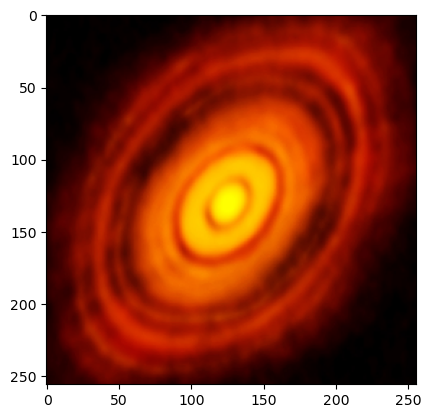

In [56]:
imagePath = path+'unseen_data/'+'HL_Tau_protoplanetary_disk.jpg'
image = cv2.imread(imagePath)

left_right_list = []
top_bottom_list = []
for i in range(image.shape[1]):
    if image[int(image.shape[0]/2),i,2] > 25:
        left_right_list.append(i)
for i in range(image.shape[0]):
    if image[i,int(image.shape[1]/2),2] > 25:
        top_bottom_list.append(i)
                    
top = top_bottom_list[0]
left = left_right_list[0]
bottom = top_bottom_list[-1]
right = left_right_list[-1]
image = np.squeeze(image) 
crop_image = image[top:bottom, left:right]
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255.
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.imshow(crop_image)
CNN.predict(np.array([crop_image]))

1/1 [==============================] - 0s 471ms/step


array([[3.4804926]], dtype=float32)

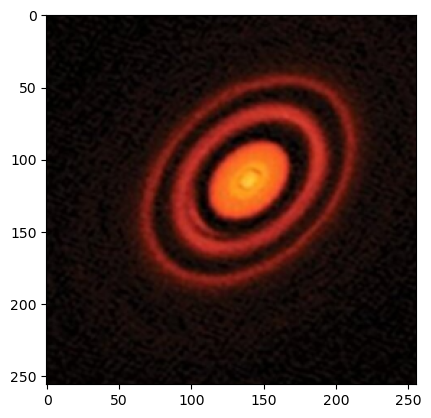

In [57]:
imagePath = path+'unseen_data/'+'HD163296.png'
image = cv2.imread(imagePath)

left_right_list = []
top_bottom_list = []
for i in range(image.shape[1]):
    if image[int(image.shape[0]/2),i,2] > 25:
        left_right_list.append(i)
for i in range(image.shape[0]):
    if image[i,int(image.shape[1]/2),2] > 25:
        top_bottom_list.append(i)
                    
top = top_bottom_list[0]
left = left_right_list[0]
bottom = top_bottom_list[-1]
right = left_right_list[-1]
image = np.squeeze(image) 
crop_image = image[top:bottom,left:right]
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255. 
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.imshow(crop_image)
CNN_C.predict(np.array([crop_image]))

1/1 [==============================] - 0s 38ms/step


array([[487.2244 ,  40.15587, 156.24544]], dtype=float32)

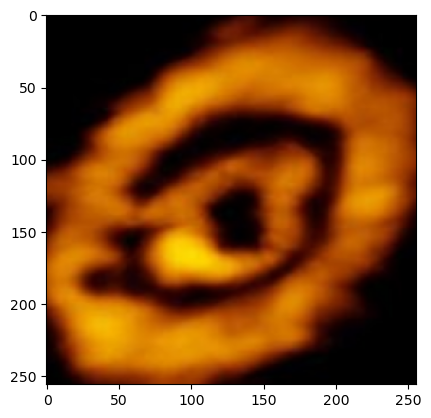

In [58]:
imagePath = path+'unseen_data/'+'IM_Lup_ALMA_NRAO.jpg'
image = cv2.imread(imagePath)

left_right_list = []
top_bottom_list = []
for i in range(image.shape[1]):
    if image[int(image.shape[0]/2),i,2] > 25:
        left_right_list.append(i)
for i in range(image.shape[0]):
    if image[i,int(image.shape[1]/2),2] > 25:
        top_bottom_list.append(i)
                    
top = top_bottom_list[0]
left = left_right_list[0]
bottom = top_bottom_list[-1]
right = left_right_list[-1]
image = np.squeeze(image) 
crop_image = image[top:bottom, left:right]
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255. 
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.grid(False)
plt.imshow(crop_image)
CNN.predict(np.array([crop_image]))

In [ ]:
imagePath = path+'unseen_data/'+'AS209_Fedele2018.jpg'
image = cv2.imread(imagePath)

top = 55
left = 35
bottom = 175
right = 190
image = np.squeeze(image) 
crop_image = image[top:bottom, left:right]
#crop_image = image
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255. 
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.grid(False)
plt.imshow(crop_image)
CNN_C.predict(np.array([crop_image]))

In [ ]:
imagePath = path+'unseen_data/'+'Sz114_Andrews2018.jpg'
image = cv2.imread(imagePath)

top = 20
left = 25
bottom = 150
right = 150
image = np.squeeze(image) 
crop_image = image[top:bottom, left:right]
#crop_image = image
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255. 
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.grid(False)
plt.imshow(crop_image)
CNN.predict(np.array([crop_image]))

In [ ]:
imagePath = path+'unseen_data/'+'DoAr25_Andrews2018.jpg'
image = cv2.imread(imagePath)

top = 40
left = 5
bottom = 130
right = 160
image = np.squeeze(image) 
crop_image = image[top:bottom, left:right]
#crop_image = image
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255. 
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.grid(False)
plt.imshow(crop_image)
CNN_C.predict(np.array([crop_image]))

In [ ]:
imagePath = path+'unseen_data/'+'AS205A_Andrews2018.jpg'
image = cv2.imread(imagePath)

top = 30
left = 20
bottom = 145
right = 150
image = np.squeeze(image) 
crop_image = image[top:bottom, left:right]
#crop_image = image
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255. 
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.grid(False)
plt.imshow(crop_image)
CNN_C.predict(np.array([crop_image]))





1/1 [==============================] - 0s 159ms/step


array([[2.064377]], dtype=float32)

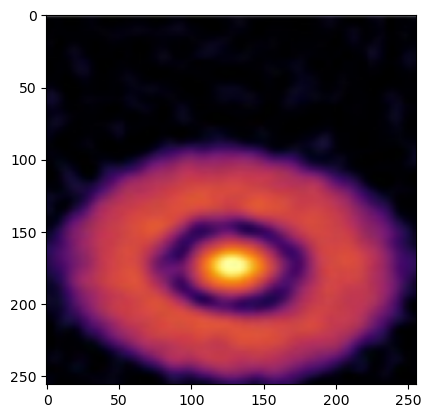

In [59]:
imagePath = path+'unseen_data/'+'SR4_Andrews2018.jpg'
image = cv2.imread(imagePath)

left_right_list = []
top_bottom_list = []
for i in range(image.shape[1]):
    if image[int(image.shape[0]/2),i,2] > 25:
        left_right_list.append(i)
for i in range(image.shape[0]):
    if image[i,int(image.shape[1]/2),2] > 25:
        top_bottom_list.append(i)
                    
top = top_bottom_list[0]
left = left_right_list[0]
bottom = top_bottom_list[-1]
right = left_right_list[-1]
image = np.squeeze(image) 
crop_image = image[top:bottom, left:right]
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255. 
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.grid(False)
plt.imshow(crop_image)
CNN_C.predict(np.array([crop_image]))

In [ ]:
imagePath = path+'unseen_data/'+'HTLup_Andrews2018.jpg'
image = cv2.imread(imagePath)

top = 55
left = 60
bottom = 115
right = 120
image = np.squeeze(image) 
crop_image = image[top:bottom, left:right]
#crop_image = image
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255. 
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.grid(False)
plt.imshow(crop_image)
CNN.predict(np.array([crop_image]))

In [ ]:
imagePath = path+'unseen_data/'+'HD143006_Andrews20182.jpg'
image = cv2.imread(imagePath)

top = 25
left = 15
bottom = 155
right = 160
image = np.squeeze(image) 
crop_image = image[top:bottom, left:right]
#crop_image = image
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255. 
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.grid(False)
plt.imshow(crop_image)
CNN_C.predict(np.array([crop_image]))

In [ ]:
imagePath = path+'unseen_data/'+'DoAr33_Andrews2018.jpg'
image = cv2.imread(imagePath)

top = 60
left = 50
bottom = 115
right = 120
image = np.squeeze(image) 
crop_image = image[top:bottom, left:right]
#crop_image = image
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255. 
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.grid(False)
plt.imshow(crop_image)
CNN_C.predict(np.array([crop_image]))

In [ ]:
imagePath = path+'unseen_data/'+'MYLup_Andrews2018.jpg'
image = cv2.imread(imagePath)

top = 45
left = 25
bottom = 145
right = 160
image = np.squeeze(image) 
crop_image = image[top:bottom, left:right]
#crop_image = image
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255. 
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.grid(False)
plt.imshow(crop_image)
CNN.predict(np.array([crop_image]))

In [ ]:
imagePath = path+'unseen_data/'+'WSB52_Andrews2018.jpg'
image = cv2.imread(imagePath)

top = 50
left = 50
bottom = 130
right = 123
image = np.squeeze(image) 
crop_image = image[top:bottom, left:right]
#crop_image = image
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255. 
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.grid(False)
plt.imshow(crop_image)
CNN.predict(np.array([crop_image]))

/opt/miniconda3/envs/proj/lib/python3.9/site-packages/keras/preprocessing/image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/miniconda3/envs/proj/lib/python3.9/site-packages/keras/preprocessing/image.py:1886: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


1/1 [==============================] - 1s 590ms/step


array([[426.79166 ,  16.334436,   8.311552]], dtype=float32)

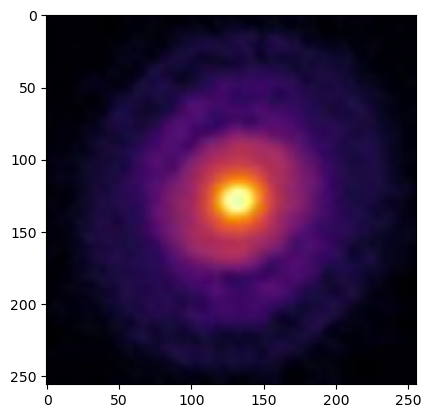

In [10]:
imagePath = path+'unseen_data/'+'WaOph6_Andrews2018.jpg'
image = cv2.imread(imagePath)
top = 12
left = 30
bottom = 160
right = 140
image = np.squeeze(image)
crop_image = image[top:bottom, left:right]
crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255. 
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)
plt.grid(False)
plt.imshow(crop_image)
CNN.predict(np.array([crop_image]))

1/1 [==============================] - 0s 69ms/step


array([[ 83.88299, 669.42096, 530.51953]], dtype=float32)

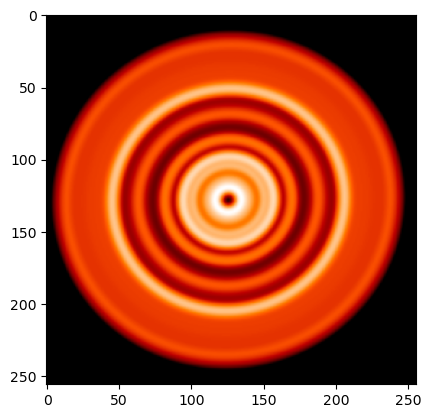

In [61]:
imagePath = path+'image_directory_complete/RT_A_1/'+'image_38.png'
image = cv2.imread(imagePath)

top = 60
left = 110
bottom = 425
right = 470

image = np.squeeze(image) 
crop_image = image[top:bottom, left:right]

# left_right_list = []
# top_bottom_list = []
# for i in range(crop_image.shape[1]):
#     print(image[int(crop_image.shape[0]/2),i,2])
#     if image[int(crop_image.shape[0]/2),i,2] < 255:
#         left_right_list.append(i)
# for i in range(crop_image.shape[0]):
#     if image[i,int(crop_image.shape[1]/2),2] < 255:
#         top_bottom_list.append(i)
                
# top = top_bottom_list[0]
# left = left_right_list[0]
# bottom = top_bottom_list[-1]
# right = left_right_list[-1]  
# crop_image = np.squeeze(crop_image) 
# crop_image = crop_image[top:bottom, left:right]

crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
crop_image = k.preprocessing.image.img_to_array(crop_image)[:,:,::-1]/255.
datagen = k.preprocessing.image.ImageDataGenerator(featurewise_center=True, zca_whitening=True)
crop_image = datagen.standardize(crop_image)

plt.grid(False)
plt.imshow(crop_image)
CNN.predict(np.array([crop_image]))